<a href="https://colab.research.google.com/github/PaulToronto/AI-and-Machine-Learning-for-Coders---Book/blob/main/3_Going_Beyond_the_Basics_Detecting_Features_in_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Going Beyond the Basics - Detecting Features in Images

The model in the previous chapter was simplified.

1. The model was trained on monochrome images
2. Each image contained only a single item of clothing
3. The item was centered within the image.

To take the model to the next level, you need to be able to detect **feautures** in images.

Instead of looking at raw pixels in the image, what if you had a way to filter the images down to constituent elements? Matching those elements, instead of raw pixels, would help us detect the contents of images more effectively.

In the Fashion MNIST dataset, when detecting a shoe, the neural network may have been activated by a lot of dark pixels clustered at the bottom of the images, which it would see as the sole of a shoe. But when the shoe is no longer centered and filling the frame, this logic doesn't hold.

One method to detect features comes from photography and image processing methodologies.

### Definition

**Convolution**: an operation performed on two functions ($f$ and $g$) to produce a third function.

Tools like Photoshop or GIMP use a mathematical filter that works on the pixels in an image to sharpen an image. Another word for these filters is a convolution.

See my Colab Notebook: <a href='https://colab.research.google.com/drive/1w0UG8EPLzCi2DyrBgbIjQpvGdK35FiXM'>6 Basic things to know about Convolutions</a> for more about how convolutions are used for image processing.

## Imports

In [1]:
from scipy.misc import ascent

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [2]:
ascent = ascent()

<ipython-input-2-dd7323a6e07c>:1: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  ascent = ascent()


In [3]:
ascent.shape, ascent.min(), ascent.max(), ascent

((512, 512),
 0,
 255,
 array([[ 83,  83,  83, ..., 117, 117, 117],
        [ 82,  82,  83, ..., 117, 117, 117],
        [ 80,  81,  83, ..., 117, 117, 117],
        ...,
        [178, 178, 178, ...,  57,  59,  57],
        [178, 178, 178, ...,  56,  57,  57],
        [178, 178, 178, ...,  57,  57,  58]]))

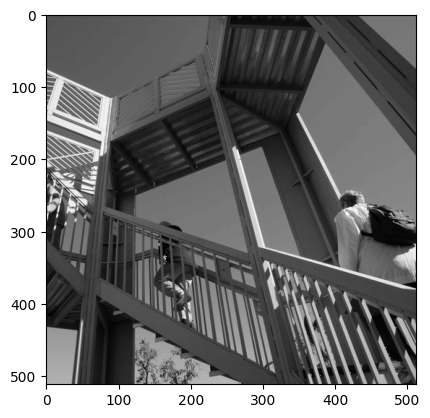

In [4]:
plt.imshow(ascent, cmap=plt.cm.gray);

## Filters

### Function to apply a filter

In [5]:
# I had trouble debugging this function
#. in order to get it to work:
# 1. I needed to convert the
#.   arrays to dtype=np.float32, that way the intermediate
#.   calculations maintained their precision
# 2. I also used np.clip since some values were out of the
#.   range of 0-255, even though cv2_imshow rendered it correctly
#.   without that
def apply_filter(img, kernel):
    # ensure the kernel is a numpy array
    img = img.astype(np.float32)
    kernel = np.array(kernel, dtype=np.float32)

    # allows the code to work with kernels of different sizes
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    # create an empty output image
    # the kernel can't easily handle the images of the borders
    # . so we omit them
    # NOTE: `cv2.filter2D` handles the borders differently
    #. it it outputs an image of the same size
    output_image = np.zeros_like(img[pad_height:-pad_height, pad_width:-pad_width], dtype=np.float32)

    for (row, col), _ in np.ndenumerate(output_image):
        img_part_correspond_2_kernel = img[row:row+kernel_height, col:col+kernel_width]

        # compute the convolution
        conv_result = np.sum(img_part_correspond_2_kernel * kernel)

        output_image[row, col] = conv_result

    output_image = np.clip(output_image, 0, 255).astype(np.uint8)

    return output_image

### Filter to emphasize vertical lines

- This filter has negative values on the left and positive values on the right

In [6]:
filter_vertical_lines = np.array([[-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]])
filter_vertical_lines

array([[-1,  0,  1],
       [-2,  0,  2],
       [-1,  0,  1]])

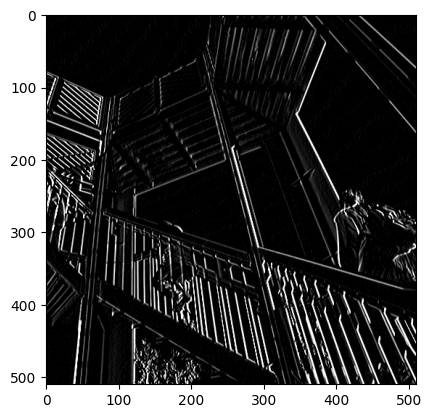

In [7]:
vertical_lines = apply_filter(ascent, filter_vertical_lines)
plt.imshow(vertical_lines, cmap=plt.cm.gray);

### Filter to emphasize horizontal lines

In [8]:
filter_horizontal_lines = np.array([[-1, -2, -1],
                                    [0, 0, 0],
                                    [1, 2,  1]])
filter_horizontal_lines

array([[-1, -2, -1],
       [ 0,  0,  0],
       [ 1,  2,  1]])

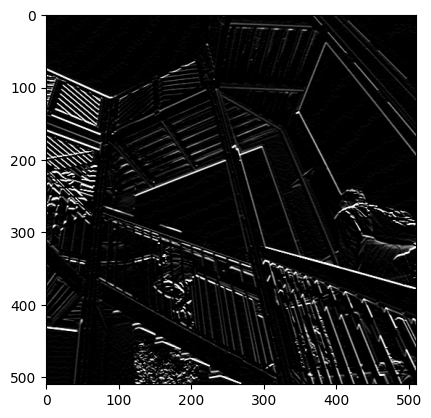

In [9]:
horizontal_lines = apply_filter(ascent, filter_horizontal_lines)
plt.imshow(horizontal_lines, cmap=plt.cm.gray);

### A neural network can *LEARN* a filter

- The above examples show that a filter can reduce the amount of information in the image
- A neural network can potentially learn a set of filters that reduce the image to features and those features can be matched to labels
    - Just as previous examples learned parameters to match inputs to output, the best filters to match inputs to outputs can be learned
- When combined with **pooling**, we can reduce the amount of information in the image while maintaining the features

## Pooling

- There are different approaches to pooling
    - max pooling
    - min pooling
    - average pooling
- Here we use max pooling by taking the maximim value from a *pool*
    - a pool in this case are all the `2 x 2` images that make up the entire image
    - this will reduce the size of the image by half

In [10]:
ascent.shape

(512, 512)

In [11]:
# the algorithm I used removed the borders
#. this could have been done without removing the borders
vertical_lines.shape

(510, 510)

- The shape after pooling will be `255 x 255`

In [12]:
def max_pooling(img):
    img_height, img_width = img.shape

    assert img_height % 2 == 0 and img_width % 2 == 0, 'Input dimensions must be even'

    output_height = img_height // 2
    output_width = img_width // 2
    output_image = np.zeros((output_height, output_width))

    # max pooling
    for i in range(output_height):
        for j in range(output_width):
            # define the 2 x 2 region
            region = img[2 * i : 2 * i + 2,
                         2 * j : 2 * j + 2]
            max_value = region.max()
            # assign max value to corresponding position in the out_image
            output_image[i, j] = max_value

    return output_image

In [13]:
ascent_after_vertical_filter_and_max_pooling = max_pooling(vertical_lines)

In [14]:
print(ascent_after_vertical_filter_and_max_pooling)

[[  8.   0.   0. ...   0.   0.   0.]
 [  6.   0.   2. ...   0.   0.   0.]
 [  4.   0.   1. ...   0.   0.   0.]
 ...
 [  0.   0.   2. ... 120.  38. 255.]
 [  0.   0.   7. ... 139. 126. 150.]
 [  0.   0.   1. ...  65. 105.  38.]]


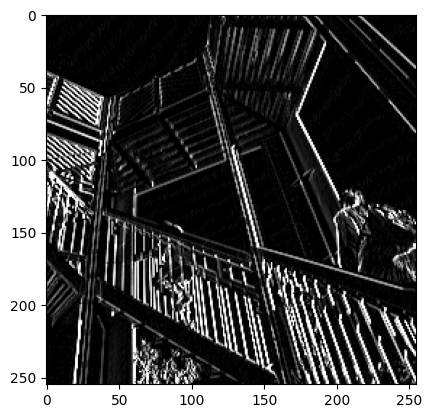

In [15]:
plt.imshow(ascent_after_vertical_filter_and_max_pooling, cmap=plt.cm.gray);

## Implementing Convolutional Neural Networks

In [16]:
# recall the code for a neural network from the last chapter
data = tf.keras.datasets.fashion_mnist

(training_images, training_labels), (testing_images, testing_labels) = data.load_data()

training_images = training_images / 255.0
testing_images = testing_images / 255.0

model = tf.keras.models.Sequential([

    # input layer
    tf.keras.layers.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),

    # hidden layer
    # number of weights: 28 * 28 * 128 + 128 = 100480
    tf.keras.layers.Dense(128, activation=tf.nn.relu),

    # output layer
    # number of weights:  128 * 10 + 10 = 1290
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
       loss='sparse_categorical_crossentropy',
       metrics=['accuracy'])

model.fit(training_images, training_labels, epochs=50, verbose=0)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
print("number of layers in model: ", len(model.layers))

number of layers in model:  3


In [19]:
model_layers0 = model.layers[0]
print("type: ", type(model_layers0))
print("weights: ", model_layers0.weights)
print("input.shape: ", model_layers0.input.shape)
print("output.shape: ", model_layers0.output.shape) # 28 * 28 = 784

type:  <class 'keras.src.layers.reshaping.flatten.Flatten'>
weights:  []
input.shape:  (None, 28, 28)
output.shape:  (None, 784)


In [20]:
model_layers1 = model.layers[1]
print("type: ", type(model_layers1))
model_layers1_weights = model_layers1.weights
print("weights length: ", len(model_layers1_weights))
print("weights[0] shape: ", model_layers1_weights[0].numpy().shape) # 784 * 128 = 100_352
print("weights[1] shape: ", model_layers1_weights[1].numpy().shape) # bias 128
print("input.shape: ", model_layers1.input.shape)
print("output.shape: ", model_layers1.output.shape)
n = model_layers0.output.shape[1] # number of input features
print("n: ", n)
m = model_layers1.units # number of neurons
print("m: ", m)
print("number of weights (n * m): ", n * m)
print("number of biases (m): ", m)
print("number of parameters: ", n * m + m)

type:  <class 'keras.src.layers.core.dense.Dense'>
weights length:  2
weights[0] shape:  (784, 128)
weights[1] shape:  (128,)
input.shape:  (None, 784)
output.shape:  (None, 128)
n:  784
m:  128
number of weights (n * m):  100352
number of biases (m):  128
number of parameters:  100480


In [21]:
model_layers2 = model.layers[2]
print("type: ", type(model_layers2))
model_layers2_weights = model_layers2.weights
print("weights length: ", len(model_layers2_weights))
print("weights[0] shape: ", model_layers2_weights[0].numpy().shape) # 128 * 10 = 1_280
print("weights[1] shape: ", model_layers2_weights[1].numpy().shape) # bias 10
print("input.shape: ", model_layers2.input.shape)
print("output.shape: ", model_layers2.output.shape)
n = model_layers1.output.shape[1] # number of input features
print("n: ", n)
m = model_layers2.units # number of neurons
print("m: ", m)
print("number of weights (n * m): ", n * m)
print("number of biases (m): ", m)
print("number of parameters: ", n * m + m)

type:  <class 'keras.src.layers.core.dense.Dense'>
weights length:  2
weights[0] shape:  (128, 10)
weights[1] shape:  (10,)
input.shape:  (None, 128)
output.shape:  (None, 10)
n:  128
m:  10
number of weights (n * m):  1280
number of biases (m):  10
number of parameters:  1290


### We need to reshape the data

- Since `Convo2D` layers are designed for multicolor images, we need to add a dimension for the number of colour channels;
    - `1` for gray scale.
    - `3` for RGB

In [22]:
(train_images, train_labels), (test_images, test_labels) = data.load_data()

train_images = train_images.reshape(60_000, 28, 28, 1)
test_images = test_images.reshape(10_000, 28, 28, 1)

train_images = train_images / 255.0
test_images = test_images / 255.0

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

In [23]:
# (number of images, image_height, image_width, num_channels)
train_images.shape

(60000, 28, 28, 1)

In [24]:
# shape of a single image
train_images[0].shape

(28, 28, 1)

Recall our model from the last chapter:

```python
model = tf.keras.models.Sequential([

    # input layer
    tf.keras.layers.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),

    # hidden layer
    # number of weights: 28 * 28 * 128 + 128 = 100480
    tf.keras.layers.Dense(128, activation=tf.nn.relu),

    # output layer
    # number of weights:  128 * 10 + 10 = 1290
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
```

To convert our model to a **convolutional neural network**, we simply use convolutional layers in our model defintion. We'll also add pooling layers.

In [25]:
model_con = tf.keras.models.Sequential([

    # the input shape has been changed, described above
    tf.keras.layers.Input(shape=(28, 28, 1)),

    # we added a Conv2D layer
    # We want the layer to learn 64 convolutions
    #. - these will be randomly initialized and over time will learn
    #.   the filter values that will work best to match the input values to
    #.   their labels
    # The size of the filter is (3, 3)
    #. - this is the most common size, can be changed but should have
    #.   odd number of axes (5, 5), (7, 7), etc.
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),

    # Pooling layer: typically right after the convolutional layer
    #. - pool size is (2, 2)
    tf.keras.layers.MaxPooling2D(2, 2),

    # Another convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),

    # Another pooling layer
    tf.keras.layers.MaxPool2D(2, 2),


    # must flatten the data for the Dense layer
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation=tf.nn.relu),

    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model_con.compile(optimizer='adam',
       loss='sparse_categorical_crossentropy',
       metrics=['accuracy'])

model_con.fit(train_images, train_labels, epochs=50, verbose=0)

model_con.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [26]:
model.evaluate(testing_images, testing_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.5130 - accuracy: 0.8882


[0.5129957795143127, 0.8881999850273132]

In [27]:
model_con.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.8744 - accuracy: 0.9102


[0.8744078874588013, 0.9101999998092651]

Adding convolutions to the neural network is increasing its ability to classify images.

In [28]:
classifications = model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


In [29]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot_fashion(image_data, label_data):
    image = image_data
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.axis('off')
    plt.title(class_names[label_data])

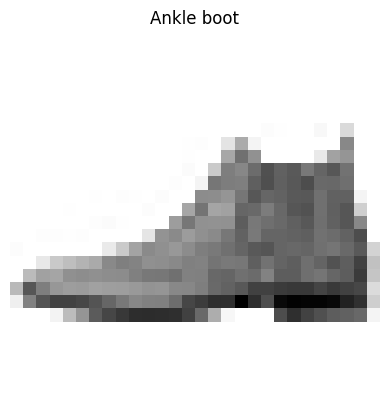

In [30]:
plot_fashion(test_images[0], test_labels[0])

## Exploring the Convolutional Network

In [31]:
model_con.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

### First Layer

```python
tf.keras.layers.Input(shape=(28, 28, 1)),
tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
```

In [32]:
first_layer = model_con.layers[0]
first_layer

In [33]:
first_layer.input_shape

(None, 28, 28, 1)

In [34]:
first_layer.output_shape

(None, 26, 26, 64)

- the first layer will have $28 \times 28$ images
- it applies 64 filters to them
- our filter has shape $3 \times 3$
    - because of the filter, part of the information in the image is lost (the border is lost)
    - our overall information is reduced from $28 \times 28$ pixels to $26 \times 26$ pixels
    - in general, an $A \times B$ pixel image, when run through a $H \times W$ filter, will become $(A - (H - 1)) \times (B - (W - 1))$ pixels
- the first layer shapes
    - input shape $\Rightarrow$ output shape
    - (None, 28, 28, 1) $\Rightarrow$ (None, 26, 26, 64)
        - the 64 is for the number of filters

In [35]:
first_layer.weights[0].shape, first_layer.weights[1].shape

(TensorShape([3, 3, 1, 64]), TensorShape([64]))

In [36]:
Filter_width = 3
Filter_height = 3
Filters = 64
Biases = 64 # one for each convolution (filter)
Filter_width * Filter_height * Filters + Biases # params

640

### Second layer

```python
tf.keras.layers.MaxPooling2D(2, 2),
```

In [37]:
second_layer = model_con.layers[1]
second_layer

In [38]:
second_layer.input_shape # same as output_shape of previous layer

(None, 26, 26, 64)

In [39]:
second_layer.output_shape

(None, 13, 13, 64)

- the pool size is $2 \times 2$, this halves it on each axis
    - input shape $\Rightarrow$ output shape
    - (None, 26, 26, 64) $\Rightarrow$ (None, 13, 13, 64)

In [40]:
second_layer.weights # the pooling layer doesn't learn anything

[]

### Third Layer

```python
tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
```

In [41]:
third_layer = model_con.layers[2]
third_layer

In [42]:
third_layer.input_shape

(None, 13, 13, 64)

In [43]:
third_layer.output_shape

(None, 11, 11, 64)

- the convolutional layer, as it did above, reduces the shape
  - input shape $\Rightarrow$ output shape
  - (None, 13, 13, 64) $\Rightarrow$ (None, 11, 11, 64)

In [44]:
len(third_layer.weights)

2

In [45]:
third_layer.weights[0].shape, third_layer.weights[1].shape

(TensorShape([3, 3, 64, 64]), TensorShape([64]))

In [46]:
Filter_width = 3
Filter_height = 3
Filters = 64 * 64 # filters x # previous filters
Biases = 64 # one for each convolution (filter)
Filter_width * Filter_height * Filters + Biases # params

36928

### Fourth Layer

```python
tf.keras.layers.MaxPool2D(2, 2),
```

In [47]:
fourth_layer = model_con.layers[3]
fourth_layer

In [48]:
fourth_layer.input_shape

(None, 11, 11, 64)

In [49]:
fourth_layer.output_shape

(None, 5, 5, 64)

- the pool size is $2 \times 2$, this halves it on each axis
    - input shape $\Rightarrow$ output shape
    - (None, 11, 11, 64) $\Rightarrow$ (None, 5, 5, 64)

In [50]:
fourth_layer.weights # the pooling layer doens't learn anything

[]

### Fifth layer

- the Flatten layer

In [51]:
fifth_layer = model_con.layers[4]
fifth_layer

In [52]:
fifth_layer.input_shape

(None, 5, 5, 64)

In [53]:
fifth_layer.output_shape # 5 * 5 * 64 = 1600

(None, 1600)

In [54]:
fifth_layer.weights # the flatten layer doens't learn anything

[]

### Sixth Layer

```python
tf.keras.layers.Dense(128, activation=tf.nn.relu),
```

In [55]:
sixth_layer = model_con.layers[5]
sixth_layer

In [56]:
sixth_layer.input_shape

(None, 1600)

In [57]:
sixth_layer.output_shape

(None, 128)

In [58]:
sixth_layer.weights[0].shape, sixth_layer.weights[1].shape

(TensorShape([1600, 128]), TensorShape([128]))

In [59]:
Number_neurons = 128
Number_biases = Number_neurons
Inputs = 1600
Number_neurons * Inputs + Number_biases # params

204928

### Seventh Layer

```python
 tf.keras.layers.Dense(10, activation=tf.nn.softmax)
 ```

In [60]:
seventh_layer = model_con.layers[6]
seventh_layer

In [61]:
seventh_layer.input_shape

(None, 128)

In [62]:
seventh_layer.output_shape

(None, 10)

In [63]:
seventh_layer.weights[0].shape, seventh_layer.weights[1].shape

(TensorShape([128, 10]), TensorShape([10]))

In [64]:
Number_neurons = 10
Number_biases = Number_neurons
Inputs = 128
Number_neurons * Inputs + Number_biases # params

1290

### Total Number Params

In [65]:
640 + 36928 + 204928 + 1290

243786

Training this network requires us to learn the best set of these 243,786 parameters to match the input limages to their labels. This is a slower process, but it builds a more accurate model